# Exercise 2: Multiband Pulse Design


Building further off of the SLR designs of exercise 1, we will now design multibanded RF pulses to excite several slices simultaneously.

Documentation for all pulse design tools can be found [here](https://sigpy.readthedocs.io/en/latest/mri_rf.html).

We again begin by importing our packages:

In [2]:
# typical sigpy and numpy imports
import numpy as np
import sigpy.mri.rf as rf # import for our RF pulse design tools 
import sigpy.plot as pl

import matplotlib.pyplot as pyplot
pyplot.rcParams.update({'figure.max_open_warning': 0})  # We'll be showing many figures

## Problem 2a: design an SLR excitation pulse

This problem is a review of the previous exercise! Design an SLR excitation pulse using the dzrf() function, and verify it produces transverse magentization. 

* Using dzrf(), design a least-squares excitation pulse with 512 samples.
* Again, use a time-bandwidth product of 8.
* Use relative maximum ripple levels in both passband and stopband of 0.01

Once you have designed and plotted the pulse, simulate it using rf.sim.abrm(), as in the previous exercise. This time, look at the Mxy profile instead of Mz. The conversion from SLR polynomials to magnetization response for an excitation pulse is :


<center>M<sub>XY</sub> = 2$\alpha\beta^*$</center>

In [3]:
tb = 8
N = 512
d1 = 0.01
d2 = 0.01
p_type = 'ex'
f_type = 'ls'

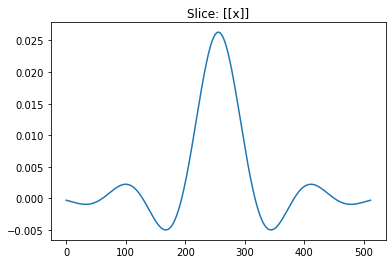

In [4]:
pulse = rf.slr.dzrf(N, tb, p_type, f_type, d1, d2)
pl.LinePlot(pulse, mode='r')

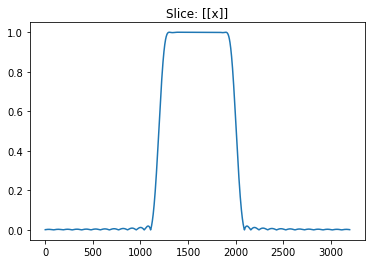

In [5]:
[a, b] = rf.sim.abrm(pulse, np.arange(-2*tb, 2*tb, 0.01), True)
Mxy = 2*np.multiply(np.conj(a), b)
pl.LinePlot(Mxy)

## Problem 2b: Multiband the excitation pulse

Now that we have a simple SLR excitation pulse designed, we can perform multibanding in order to have the pulse excite several slices simultaneously.

* Use the *rf.multiband.mb_rf()* function to create a pulse that excites 5 slices.
* Separate the pulses by 3 slice widths
* Experiment with designing the pulse with all 3 of the provided phase schedules. For this example, the differences should be minimal.

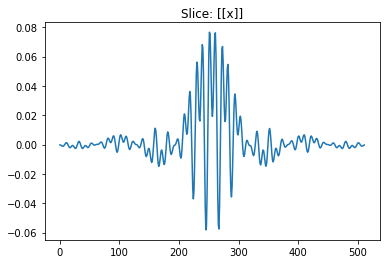

In [10]:
n_bands = 5
phs_type = 'quad_mod' # phsMod, ampMod, or quadMod
band_sep = 3*tb # separate by 3 slice widths
mb_pulse = rf.multiband.mb_rf(pulse, n_bands, band_sep, phs_type)
pl.LinePlot(mb_pulse, mode='r')

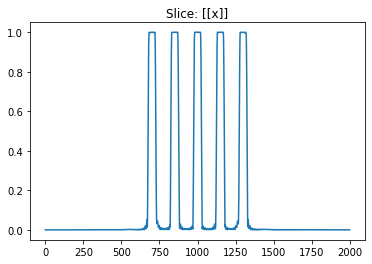

In [55]:
[a, b] = rf.sim.abrm(mb_pulse, np.arange(-20*tb, 20*tb, 40*tb/2000), True)
Mxy = 2*np.multiply(np.conj(a), b)
pl.LinePlot(Mxy)

## Problem 2c: PINS Pulse Design

Now, let's try to directly design a multiband pulse using the PINS (Power Independent Number of Slices) method. PINS interleaves a train of nonselective rectangular RF pulses that sample a slice-selective envelope with small slice gradient blips (in the Fourier domain, equivalent to convolving a single-slice profile with a train of delta functions). Unlike the previous examples, we will design this pulse with specific instead of arbitrary units in mind: 

* Given:
    * A maximum gradient amplitude of 4 gauss/cm
    * A maximum gradient slew rate of 18000 gauss/cm/s
    * A hardware dwell time of 4e-6 seconds
    * A maximum b1 amplitude of 0.18 gauss.


* Design both rf waveforms and gradients necessary to excite a series of slices that are:
    * Separated by 2.5 cm
    * With a slice thickness of 0.3 cm

* Simulate the transverse magnetization profile using the rf.sim.abrm() simulator. 

Skeleton code for plotting with the appropriate units is made available below.

In [78]:
sl_sep = 2.5 # cm
sl_thick = 0.3 # cm
g_max = 4 # gauss/cm
g_slew = 18000 # gauss/cm/s
dt = 4e-6 # seconds, dwell time
b1_max = 0.18 # gauss
[rf_pins, g_pins] = rf.multiband.dz_pins(tb, sl_sep, sl_thick, g_max, g_slew, dt, b1_max, p_type, f_type, d1, d2)

Text(0.5, 0, 'milliseconds')

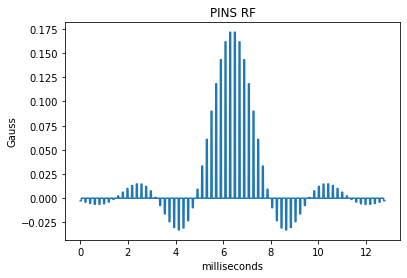

In [79]:
t = np.arange(0, np.size(rf_pins)) * dt
pyplot.figure()
pyplot.plot(t * 1000, np.real(rf_pins))
pyplot.title('PINS RF')
pyplot.ylabel('Gauss')
pyplot.xlabel('milliseconds')

Text(0.5, 0, 'milliseconds')

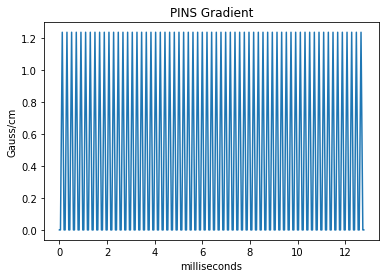

In [80]:
pyplot.figure()
pyplot.plot(t * 1000, g_pins)
pyplot.title('PINS Gradient')
pyplot.ylabel('Gauss/cm')
pyplot.xlabel('milliseconds')

In [76]:
# simulate it with Bloch simulator
x = np.reshape(np.arange(-1000, 1000), (2000, 1)) / 1000 * 12 # cm
[a, b] = rf.sim.abrm_nd(2 * np.pi * dt * 4258 * rf_pins, x, 
                        np.reshape(g_pins, (np.size(g_pins), 1)) * 4258 * dt * 2 * np.pi)
Mxy = 2 * a * np.conj(b)

Text(0.5, 0, 'cm')

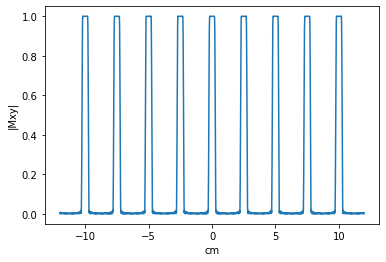

In [77]:
pyplot.figure()
pyplot.plot(x, np.abs(Mxy))
pyplot.ylabel('|Mxy|')
pyplot.xlabel('cm')